In [2]:
#pip installs
!pip3 install -q ipython-autotime
!pip3 install h5py -q
!pip3 install qiskit qiskit-algorithms qiskit-machine-learning qiskit-aer -q
!pip install pylatexenc -q

In [3]:
%reload_ext autotime

import numpy as np
from matplotlib import pyplot as plt

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from collections import OrderedDict

import gc
import h5py
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler

import random
import librosa

# import pennylane as qml
# from scipy.optimize import minimize
from tqdm import tqdm
from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliFeatureMap, RealAmplitudes,ZZFeatureMap, EfficientSU2
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
from qiskit_machine_learning.algorithms import VQC
from qiskit_aer.primitives import Sampler
from IPython.display import clear_output

time: 7.2 s (started: 2024-11-26 09:27:48 +00:00)


In [4]:
class SplitDataset(Dataset):
    def __init__(self, h5_file, indices):
        self.h5_file = h5_file
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as hf:
            index = self.indices[idx]
            spectrogram = hf['spectrograms'][index] / 255.0  # Load one item and normalize
            label = hf['labels'][index]
            spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
            spectrogram = spectrogram.unsqueeze(0)
            label = torch.tensor(label, dtype=torch.long)

            # Call garbage collector periodically
            if idx % 1000 == 0:
                gc.collect()
            
            return spectrogram, label

def create_splits(h5_path, test_split=0.1, val_split=0.2, seed=42):
    """Create dataset splits without loading entire dataset"""
    # Get dataset size without loading data
    with h5py.File(h5_path, 'r') as f:
        total_size = len(f['spectrograms'])
        labels = f['labels'][:]

    labels = labels.argmax(axis=1)
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # Generate globally shuffled indices
    rng = np.random.RandomState(seed)
    all_indices = np.arange(total_size)
    rng.shuffle(all_indices)
    
    # Calculate split sizes
    test_size = int(test_split * total_size)
    val_size = int(val_split * total_size)
    train_size = total_size - test_size - val_size
    
    # Create index lists for each split
    test_indices = all_indices[:test_size]
    val_indices = all_indices[test_size:test_size + val_size]
    train_indices = all_indices[test_size + val_size:]
    
    # Create datasets using your SplitDataset class
    train_dataset = SplitDataset(h5_path, train_indices)
    val_dataset = SplitDataset(h5_path, val_indices)
    test_dataset = SplitDataset(h5_path, test_indices)
    
    return train_dataset, val_dataset, test_dataset, class_weights

def create_data_loaders(h5_path, batch_size=32, test_split=0.1, val_split=0.2,
                       seed=42, num_workers=4):
    """Create data loaders with memory-efficient splitting"""
    
    # Clear memory before creating splits
    gc.collect()
    torch.cuda.empty_cache()
    
    # Create datasets
    train_dataset, val_dataset, test_dataset, class_weights = create_splits(
        h5_path, test_split, val_split, seed
    )
    
    # Create data loaders with optimized settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,  # No need to shuffle validation
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,  # No need to shuffle test
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True
    )
    
    return train_loader, val_loader, test_loader, class_weights

DATASET_SIZE = 105526
BATCH_SIZE = 32
TEST_SPLIT = 0.1
VAL_SPLIT = 0.2
NUM_WORKERS = 4
H5_PATH = '/kaggle/input/raga-ieee-preprocessing/processed_spectrograms.h5'

train_loader, val_loader, test_loader, class_weights = create_data_loaders(
        h5_path=H5_PATH,
        batch_size=BATCH_SIZE,
        test_split=TEST_SPLIT,
        val_split=VAL_SPLIT,
        num_workers=NUM_WORKERS,
        seed=420
    )

print(f"\nDataset splits:")
print(f"Train size: {len(train_loader.dataset)}")
print(f"Val size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")


Dataset splits:
Train size: 73869
Val size: 21105
Test size: 10552
time: 2.15 s (started: 2024-11-26 09:27:55 +00:00)


In [5]:
class CNN_with_BottleNeck(nn.Module):
    def __init__(self):
        super(CNN_with_BottleNeck, self).__init__()
        
        # Feature extraction blocks
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # (256x256) -> (128x128)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout2d(p=0.1)  # Dropout after conv1
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # (128x128) -> (64x64)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout2d(p=0.15)  # Dropout after conv2
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # (64x64) -> (32x32)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout2d(p=0.15)  # Dropout after conv3
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)  # (32x32) -> (16x16)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout2d(p=0.15)  # Dropout after conv4
        
        # Additional convolutional block for better feature extraction
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)  # (16x16) -> (8x8)
        self.bn5 = nn.BatchNorm2d(512)
        self.dropout5 = nn.Dropout2d(p=0.2)  # Dropout after conv5
        
        # Bottleneck: Progressive channel reduction
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, kernel_size=1)
        )
        
        # Global average pooling for spatial reduction
        self.global_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Classification head
        self.fc = nn.Linear(1 * 4 * 4, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)  # Apply dropout after conv1
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)  # Apply dropout after conv2
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)  # Apply dropout after conv3
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.dropout4(x)  # Apply dropout after conv4
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool5(x)
        x = self.dropout5(x)  # Apply dropout after conv5
        
        x = self.bottleneck(x)  # Shape: (batch_size, 1, 8, 8)
        x = self.global_pool(x)  # Shape: (batch_size, 1, 4, 4)
        
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 16)
        x = self.fc(x)  # Shape: (batch_size, 10)
        
        return x

time: 3.2 ms (started: 2024-11-26 09:27:57 +00:00)


In [6]:
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])  # Remove last layer

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)  # Flatten to 16-dimension vector

time: 11.4 ms (started: 2024-11-26 09:27:57 +00:00)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN_with_BottleNeck()
checkpoint = torch.load(
    '/kaggle/input/raga-ieee-autoencoder/best_model_4x4_dropout_2.pth',
    map_location=device,
    weights_only=False
)

new_state_dict = OrderedDict()
for key, value in checkpoint['model_state_dict'].items():
    new_key = key.replace("module.", "")  # Remove `module.` prefix
    new_state_dict[new_key] = value

cnn_model.load_state_dict(new_state_dict)
cnn_model.eval()

feature_extractor = FeatureExtractor(cnn_model)
feature_extractor.eval()

FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.15, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout2d(p=0.15, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1

time: 283 ms (started: 2024-11-26 09:27:57 +00:00)


In [9]:
# X_train = []
# Y_train = []

# for spectrograms, labels in train_loader:
#     with torch.no_grad():
#         features = feature_extractor(spectrograms)  # Process entire batch
#     features = features.view(features.size(0), -1)  # Flatten
#     features /= features.norm(dim=1, keepdim=True) + 1e-8  # Normalize per sample

#     X_train.append(features.numpy())
#     Y_train.append(labels.argmax(dim=1).numpy())

# X_train = np.vstack(X_train)
# Y_train = np.hstack(Y_train)

time: 1h 24min 50s (started: 2024-11-26 05:25:22 +00:00)


In [12]:
# X_test = []
# Y_test = []

# for spectrograms, labels in test_loader:
#     with torch.no_grad():
#         features = feature_extractor(spectrograms)  # Process entire batch
#     features = features.view(features.size(0), -1)  # Flatten
#     features /= features.norm(dim=1, keepdim=True) + 1e-8  # Normalize per sample

#     X_test.append(features.numpy())
#     Y_test.append(labels.argmax(dim=1).numpy())

# X_test = np.vstack(X_test)
# Y_test = np.hstack(Y_test)

time: 12min 14s (started: 2024-11-26 08:09:10 +00:00)


In [8]:
X_train = []
Y_train = []
TRAIN_SIZE = 100

data_iter = iter(train_loader)
for i in range(TRAIN_SIZE):
    spectrograms, labels = next(data_iter)
    random_idx = random.randint(0, spectrograms.size(0) - 1)
    spectrogram = spectrograms[random_idx].squeeze().numpy()
    label = labels[random_idx].argmax().item()
    input_tensor = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        cnn_output = feature_extractor(input_tensor)
    x = cnn_output.numpy().reshape(16,)
    x = x / np.max(np.abs(x))
    X_train.append(x)
    Y_train.append(label)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

time: 25.9 s (started: 2024-11-26 09:27:58 +00:00)


In [9]:
X_test = []
Y_test = []
TEST_SIZE = 10

data_iter = iter(test_loader)
for i in range(TEST_SIZE):
    spectrograms, labels = next(data_iter)
    random_idx = random.randint(0, spectrograms.size(0) - 1)
    spectrogram = spectrograms[random_idx].squeeze().numpy()
    label = labels[random_idx].argmax().item()
    input_tensor = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    with torch.no_grad():
        cnn_output = feature_extractor(input_tensor)
    x = cnn_output.numpy().reshape(16,)
    x = x / np.max(np.abs(x))
    X_test.append(x)
    Y_test.append(label)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

time: 3.74 s (started: 2024-11-26 09:28:23 +00:00)


In [ ]:
# Get one random batch from the train_loader
data_iter = iter(train_loader)
spectrograms, labels = next(data_iter)

# Select a random index within the batch
random_idx = random.randint(0, spectrograms.size(0) - 1)

# Get the spectrogram and label at that index
spectrogram = spectrograms[random_idx].squeeze().numpy()
label = labels[random_idx].argmax().item()  # Assuming one-hot encoded labels

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
librosa.display.specshow(spectrogram, 
                             sr=16000, 
                             hop_length=512, 
                             x_axis='time', 
                             y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel Spectrogram for {label}")
plt.tight_layout()

plt.subplot(1, 2, 2)
input_tensor = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
with torch.no_grad():
    cnn_output = feature_extractor(input_tensor)

plt.imshow(torch.reshape(cnn_output, (4,4)), cmap='viridis', interpolation='nearest')
plt.colorbar(label="Feature Intensity")
plt.title("4x4 Feature Matrix")

plt.show()


In [10]:
num_features = 16
# feature_map = PauliFeatureMap(
#         feature_dimension=num_features,
#         reps=3,
#         # paulis=["Z", "X", "ZZ"]  # Pauli gates
#         paulis=["Z", "ZZ"]
#     )

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=3)
# ansatz = RealAmplitudes(num_qubits=num_features, reps=2)
ansatz = EfficientSU2(num_qubits=num_features, entanglement='full', reps=2)
optimizer = COBYLA(maxiter=100)
sampler = Sampler()

time: 13.4 ms (started: 2024-11-26 09:28:27 +00:00)


In [11]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

time: 9.07 ms (started: 2024-11-26 09:28:27 +00:00)


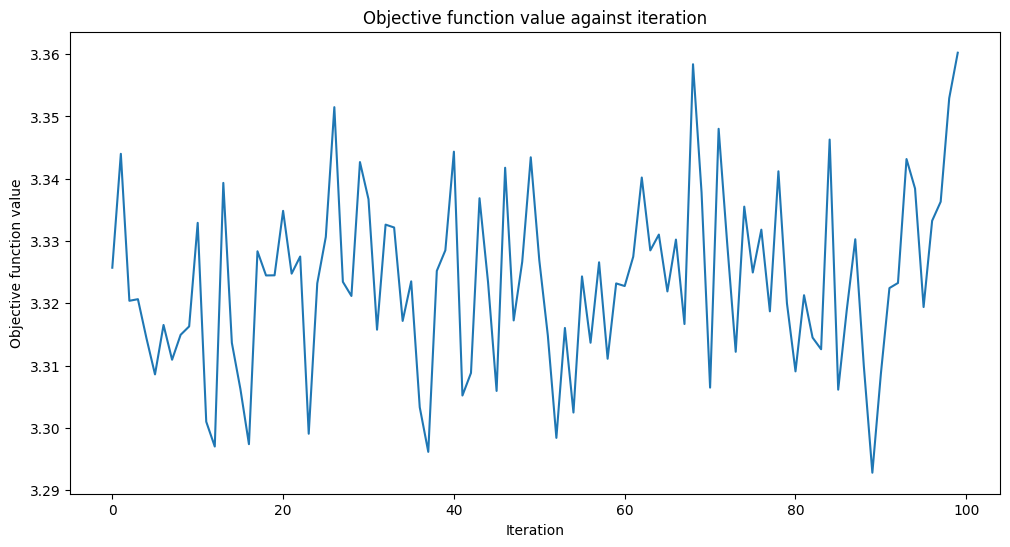

time: 29min 38s (started: 2024-11-26 09:28:27 +00:00)


In [12]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

vqc.fit(X_train, Y_train)

In [13]:
train_score_q4 = vqc.score(X_train, Y_train)
test_score_q4 = vqc.score(X_test, Y_test)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.11
Quantum VQC on the test dataset:     0.20
time: 20.2 s (started: 2024-11-26 10:10:43 +00:00)
